In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['Macrophages']), :]
adata

View of AnnData object with n_obs × n_vars = 26248 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [6]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 26248 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group'],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=15, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

# 2. Determine optimal cluster resolution for cell subset annotation

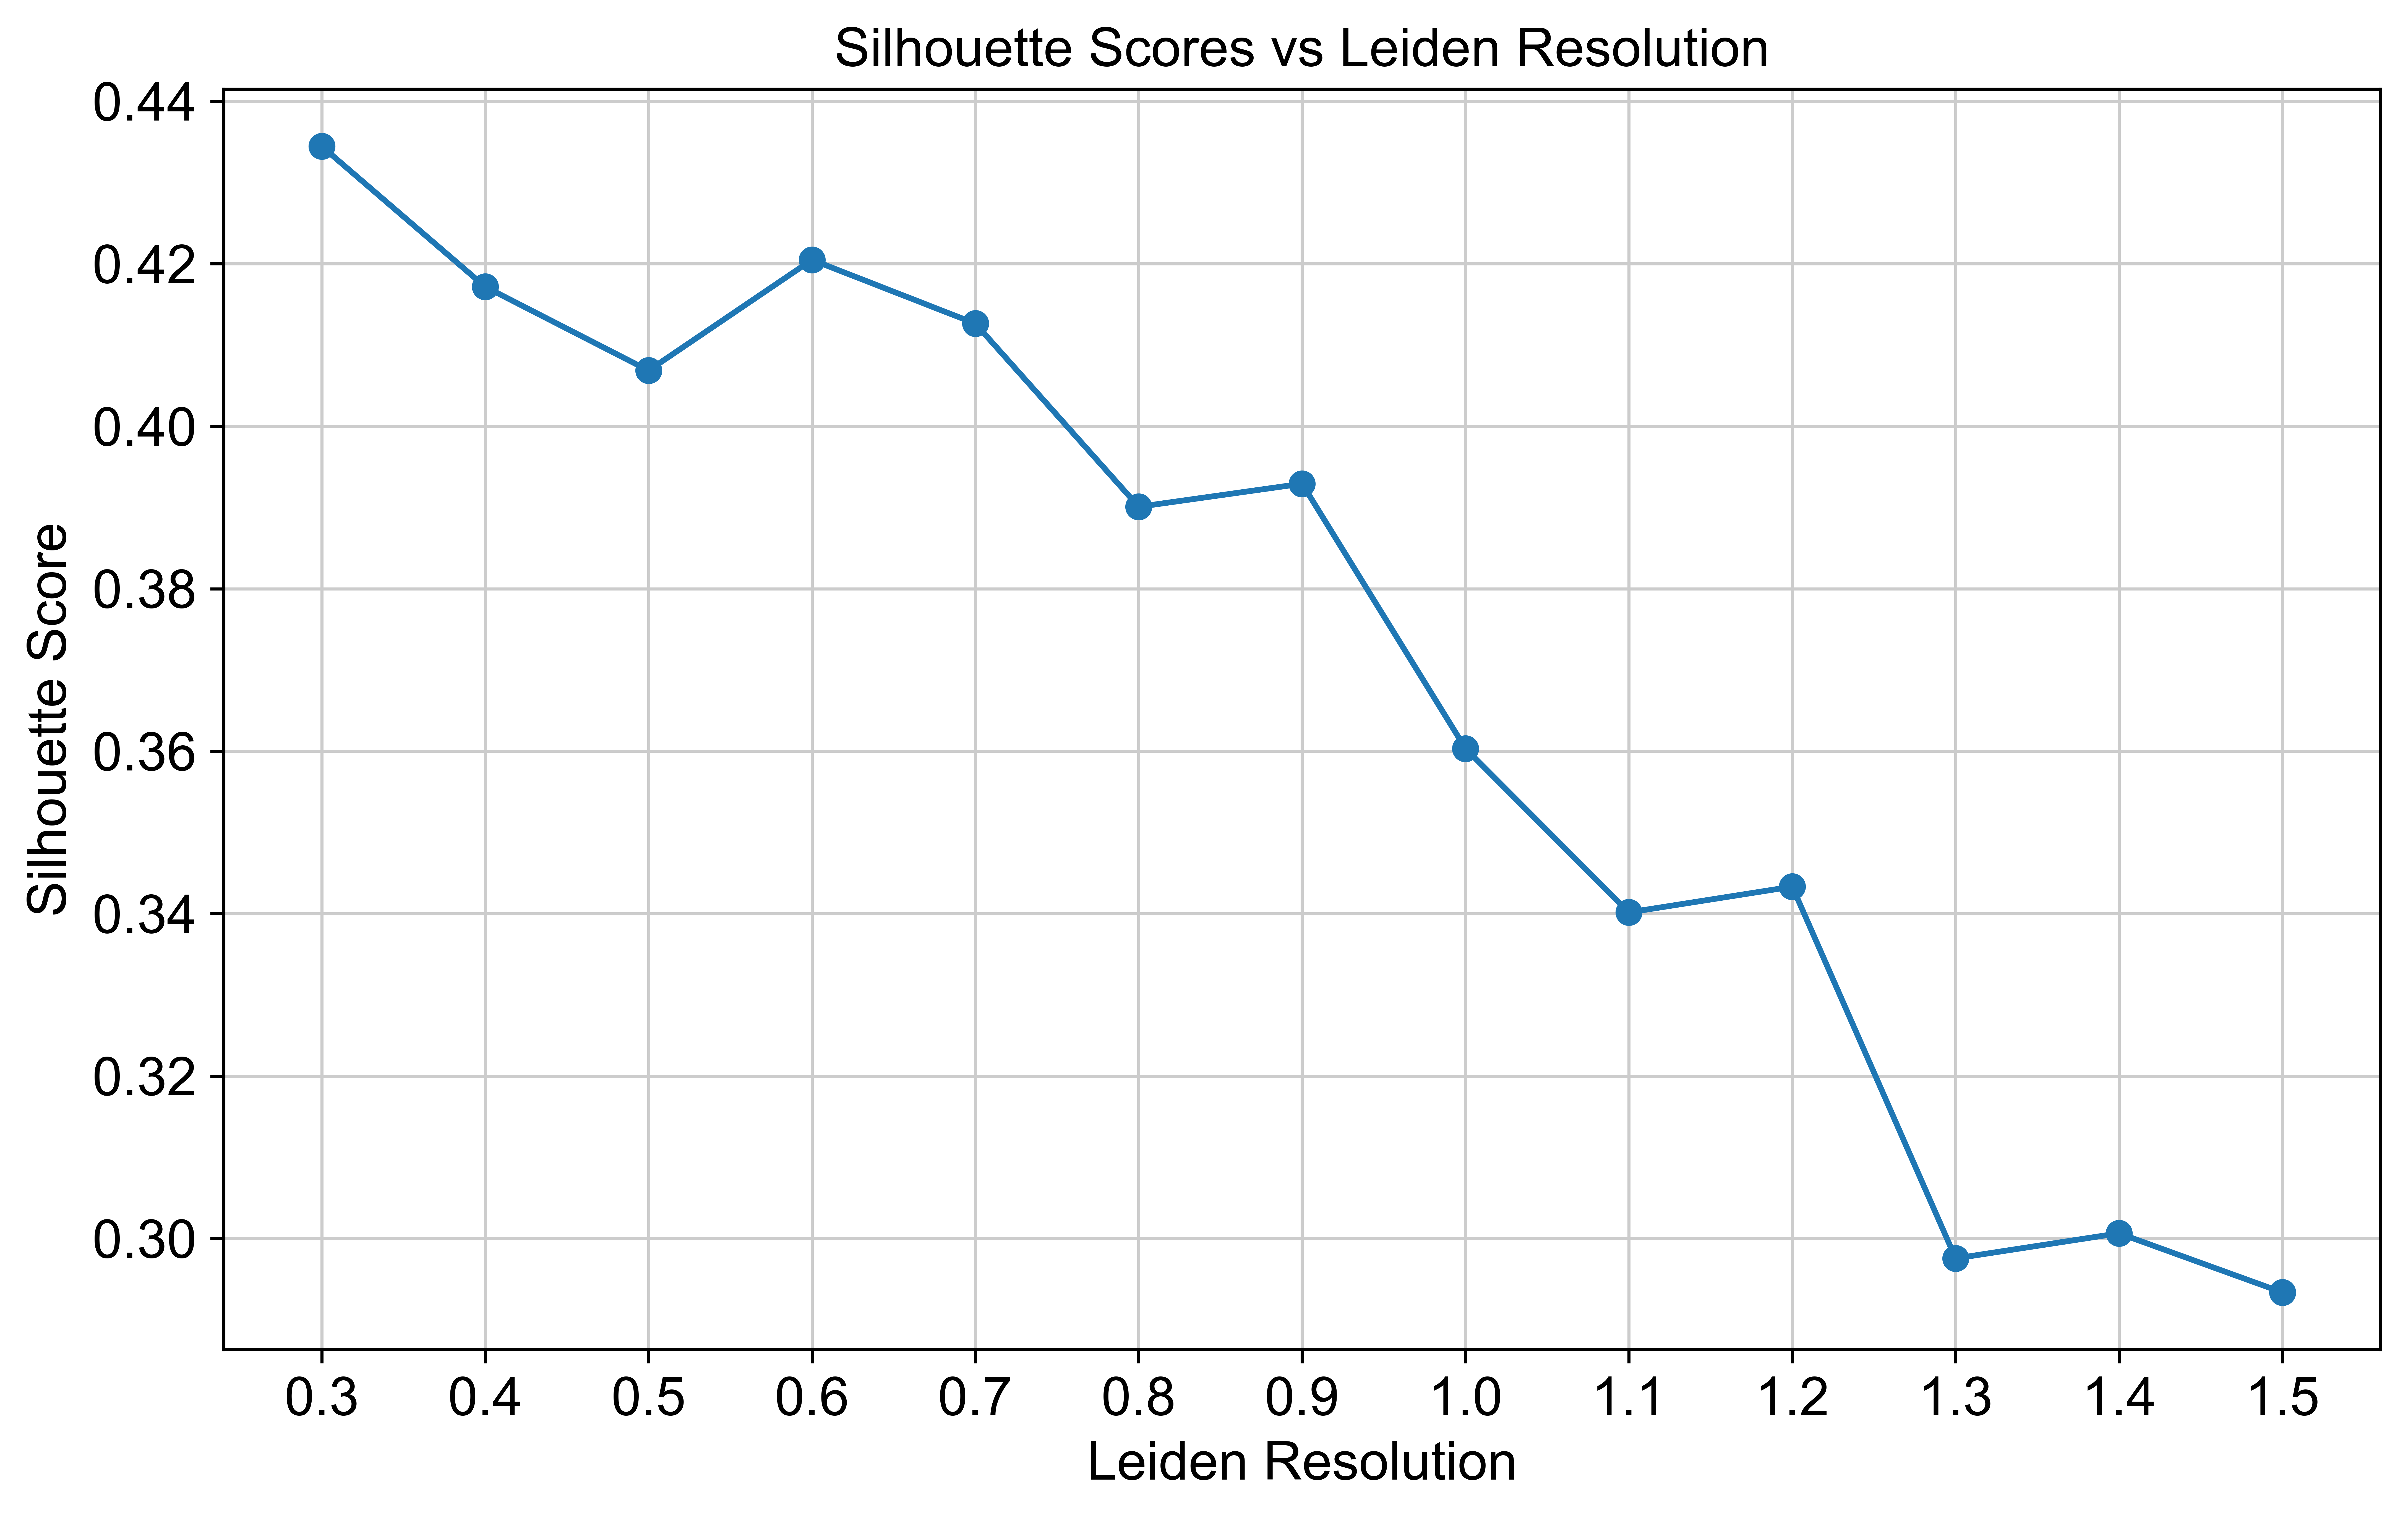

In [12]:
import sklearn
from sklearn.metrics import silhouette_score  
# define resolutions to be tested
resolutions = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

silhouette_scores = []

# calculate silhouette scores for each resolution
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f"leiden_res{res}")
    
    score = sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs[f"leiden_res{res}"], metric='euclidean')
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(resolutions, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Leiden Resolution')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.xticks(resolutions)
plt.grid(True)
plt.show()


leiden_res0.6 is stable and has resolved pDCs cDC1 cDC2 and monocytes so we will use this resolution fo cell type annotation


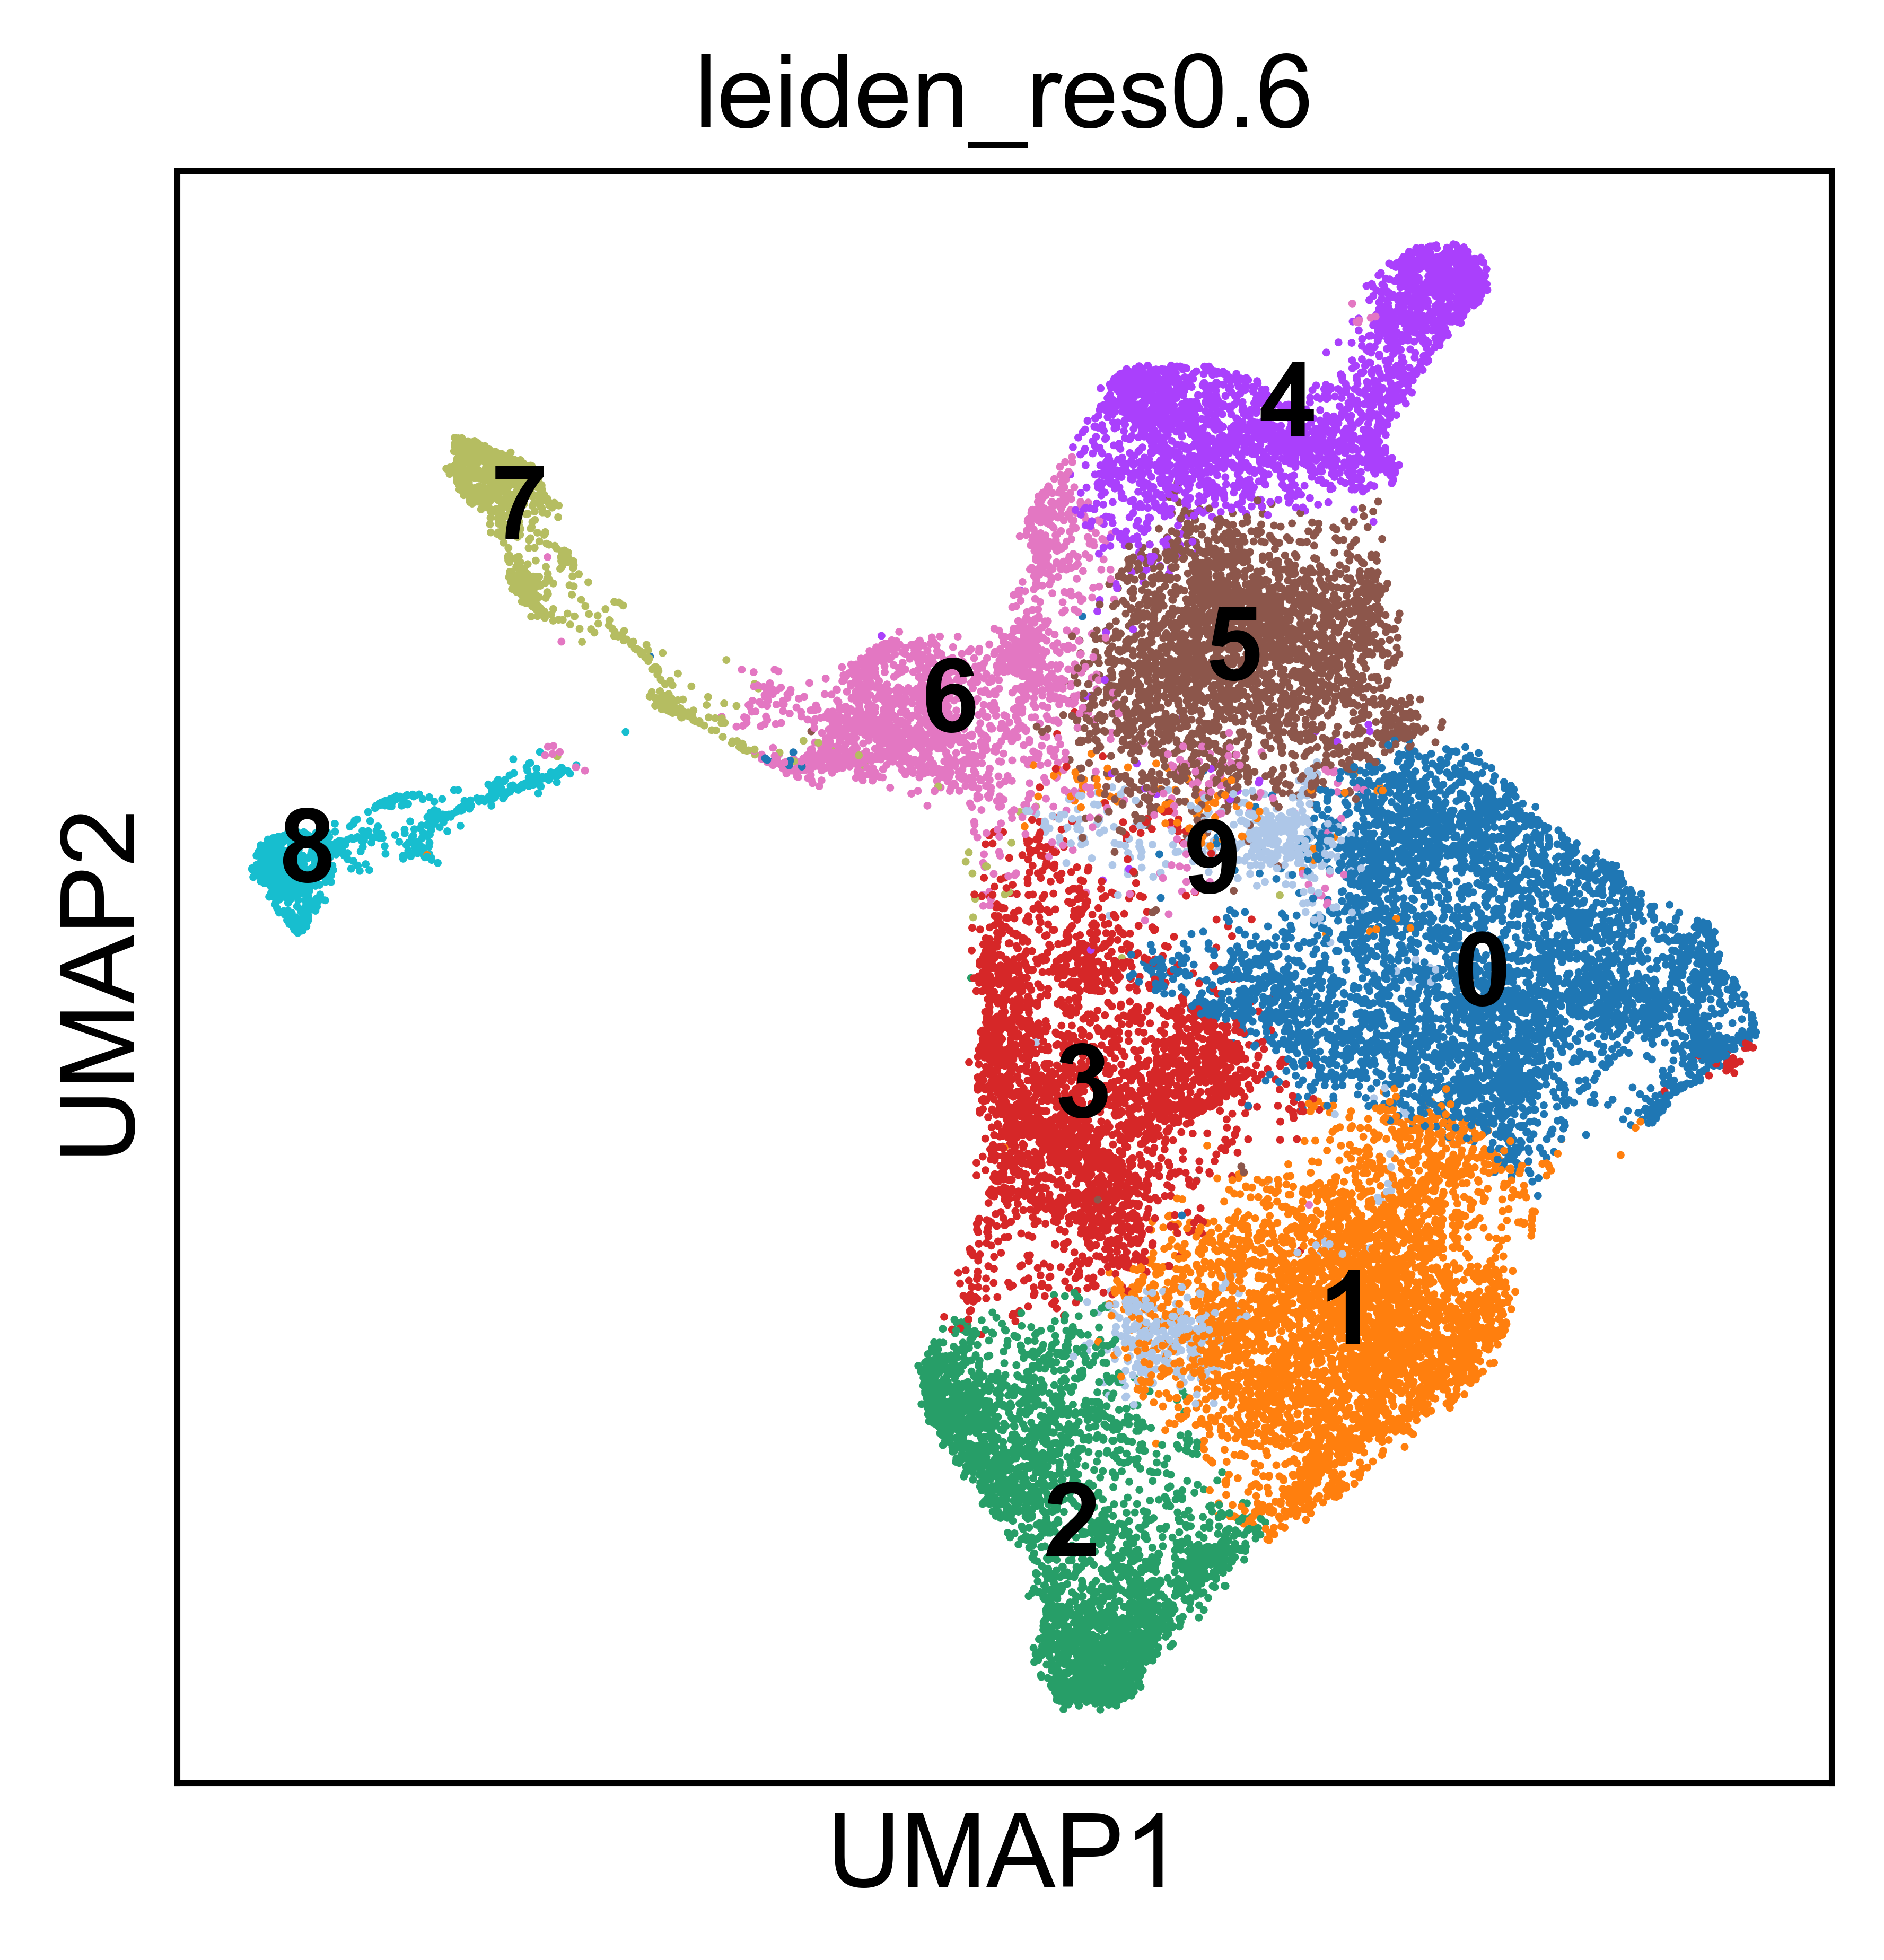

In [26]:
sc.pl.umap(adata, color = ["leiden_res0.6"],legend_loc='on data')


In [24]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden_res0.6', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))



0             1             2             3             4  \
0          CXCL9          LGMN         FABP4          C1QB           CFP   
1           IDO1          APOE        MCEMP1          C1QA        S100A4   
2             CP          C1QB         MARCO           HBB          VCAN   
3         CXCL11          C1QA          MRC1          CD5L         TIMP1   
4           SOD2         GPNMB          CD36  LOC101865442      TNFRSF1B   
5         FAM26F          C1QC         FABP5        CHRDL1        FAM65B   
6        RARRES3  LOC102130734         RMDN3  LOC102136846          FCN1   
7         CLEC6A         FUCA1       NGFRAP1         CALB2  LOC102120967   
8         CXCL10      ADAMDEC1  LOC102129811          C1QC    C9H10orf54   
9           WARS          CTSC         CCL18        CXCL13           CFD   
10           UBD          CTSB          RETN         SPARC         PTGS2   
11         SNX10        DNASE2         ALDH2         LYPD1         PLBD1   
12       ANKRD22        OLFML3         CHIT1          RRM2           FGR   
13  LOC102147203           CPM         PPARG         HTRA1         THBS1   
14  LOC102146847         APOC1          CDH1  LOC102136493         ITGA4   
15         ALAS1          LIPA         ITGA6  LOC102136192      APOBEC3B   
16        LILRB4       SLCO2B1          SMC6         MKI67        ZNF703   
17         DRAM1         TREM2         LTA4H         NCAPG          EHD1   
18         IL2RA         MS4A7         ABCG1         NTRK2        INSIG1   
19        NEURL3        ABHD12          SDC2       SPARCL1          EREG   

             5             6             7            8             9  
0        THBS1          JAML        CLEC9A       CCDC50        LGALS3  
1         FCN1          CPVL  LOC102121644         SELL  LOC102129822  
2         IL1B  LOC102137734          FLT3       LILRA4           FN1  
3        F13A1          CD1C          LSP1         GZMB         GPNMB  
4         AREG          PKIB          CLNK         TCF4         PRDX1  
5        VEGFA        CORO1A      SERPINB9         IRF7          OLR1  
6        TIMP1       FAM129A         CADM1        ITM2C          CTSB  
7       FCGR2B          CD33     C1H1orf54        PTPRS          APOE  
8         EREG         PLCB2        TBC1D8         IRF8         RMDN3  
9        IL1RN          CNN2       TSPAN33       BCL11A          CD63  
10     CLEC10A  LOC102122749           ID2      TSPAN13        MCEMP1  
11        CPVL       CLEC10A  LOC102122749        SUSD1          GPX1  
12        IER3          FLT3          CPVL         GAS6        ERV3-1  
13      INSIG1          LSP1         BATF3        EGLN3         MMP14  
14      CDKN1A         MEF2C          CST3        MSRB3        CLEC6A  
15        G0S2          PID1         BASP1  C11H12orf75        PLXDC2  
16        VCAN         PARM1        ADAM19        TNNI2         ANXA2  
17      FCGR2A         WNT5A         GCSAM        SULF2         ASAH1  
18  C9H10orf54          MNDA         CD226       SLC7A5       SLC37A2  
19        IDO1        BCL11A         CSRP1         SOX4         PDIA6

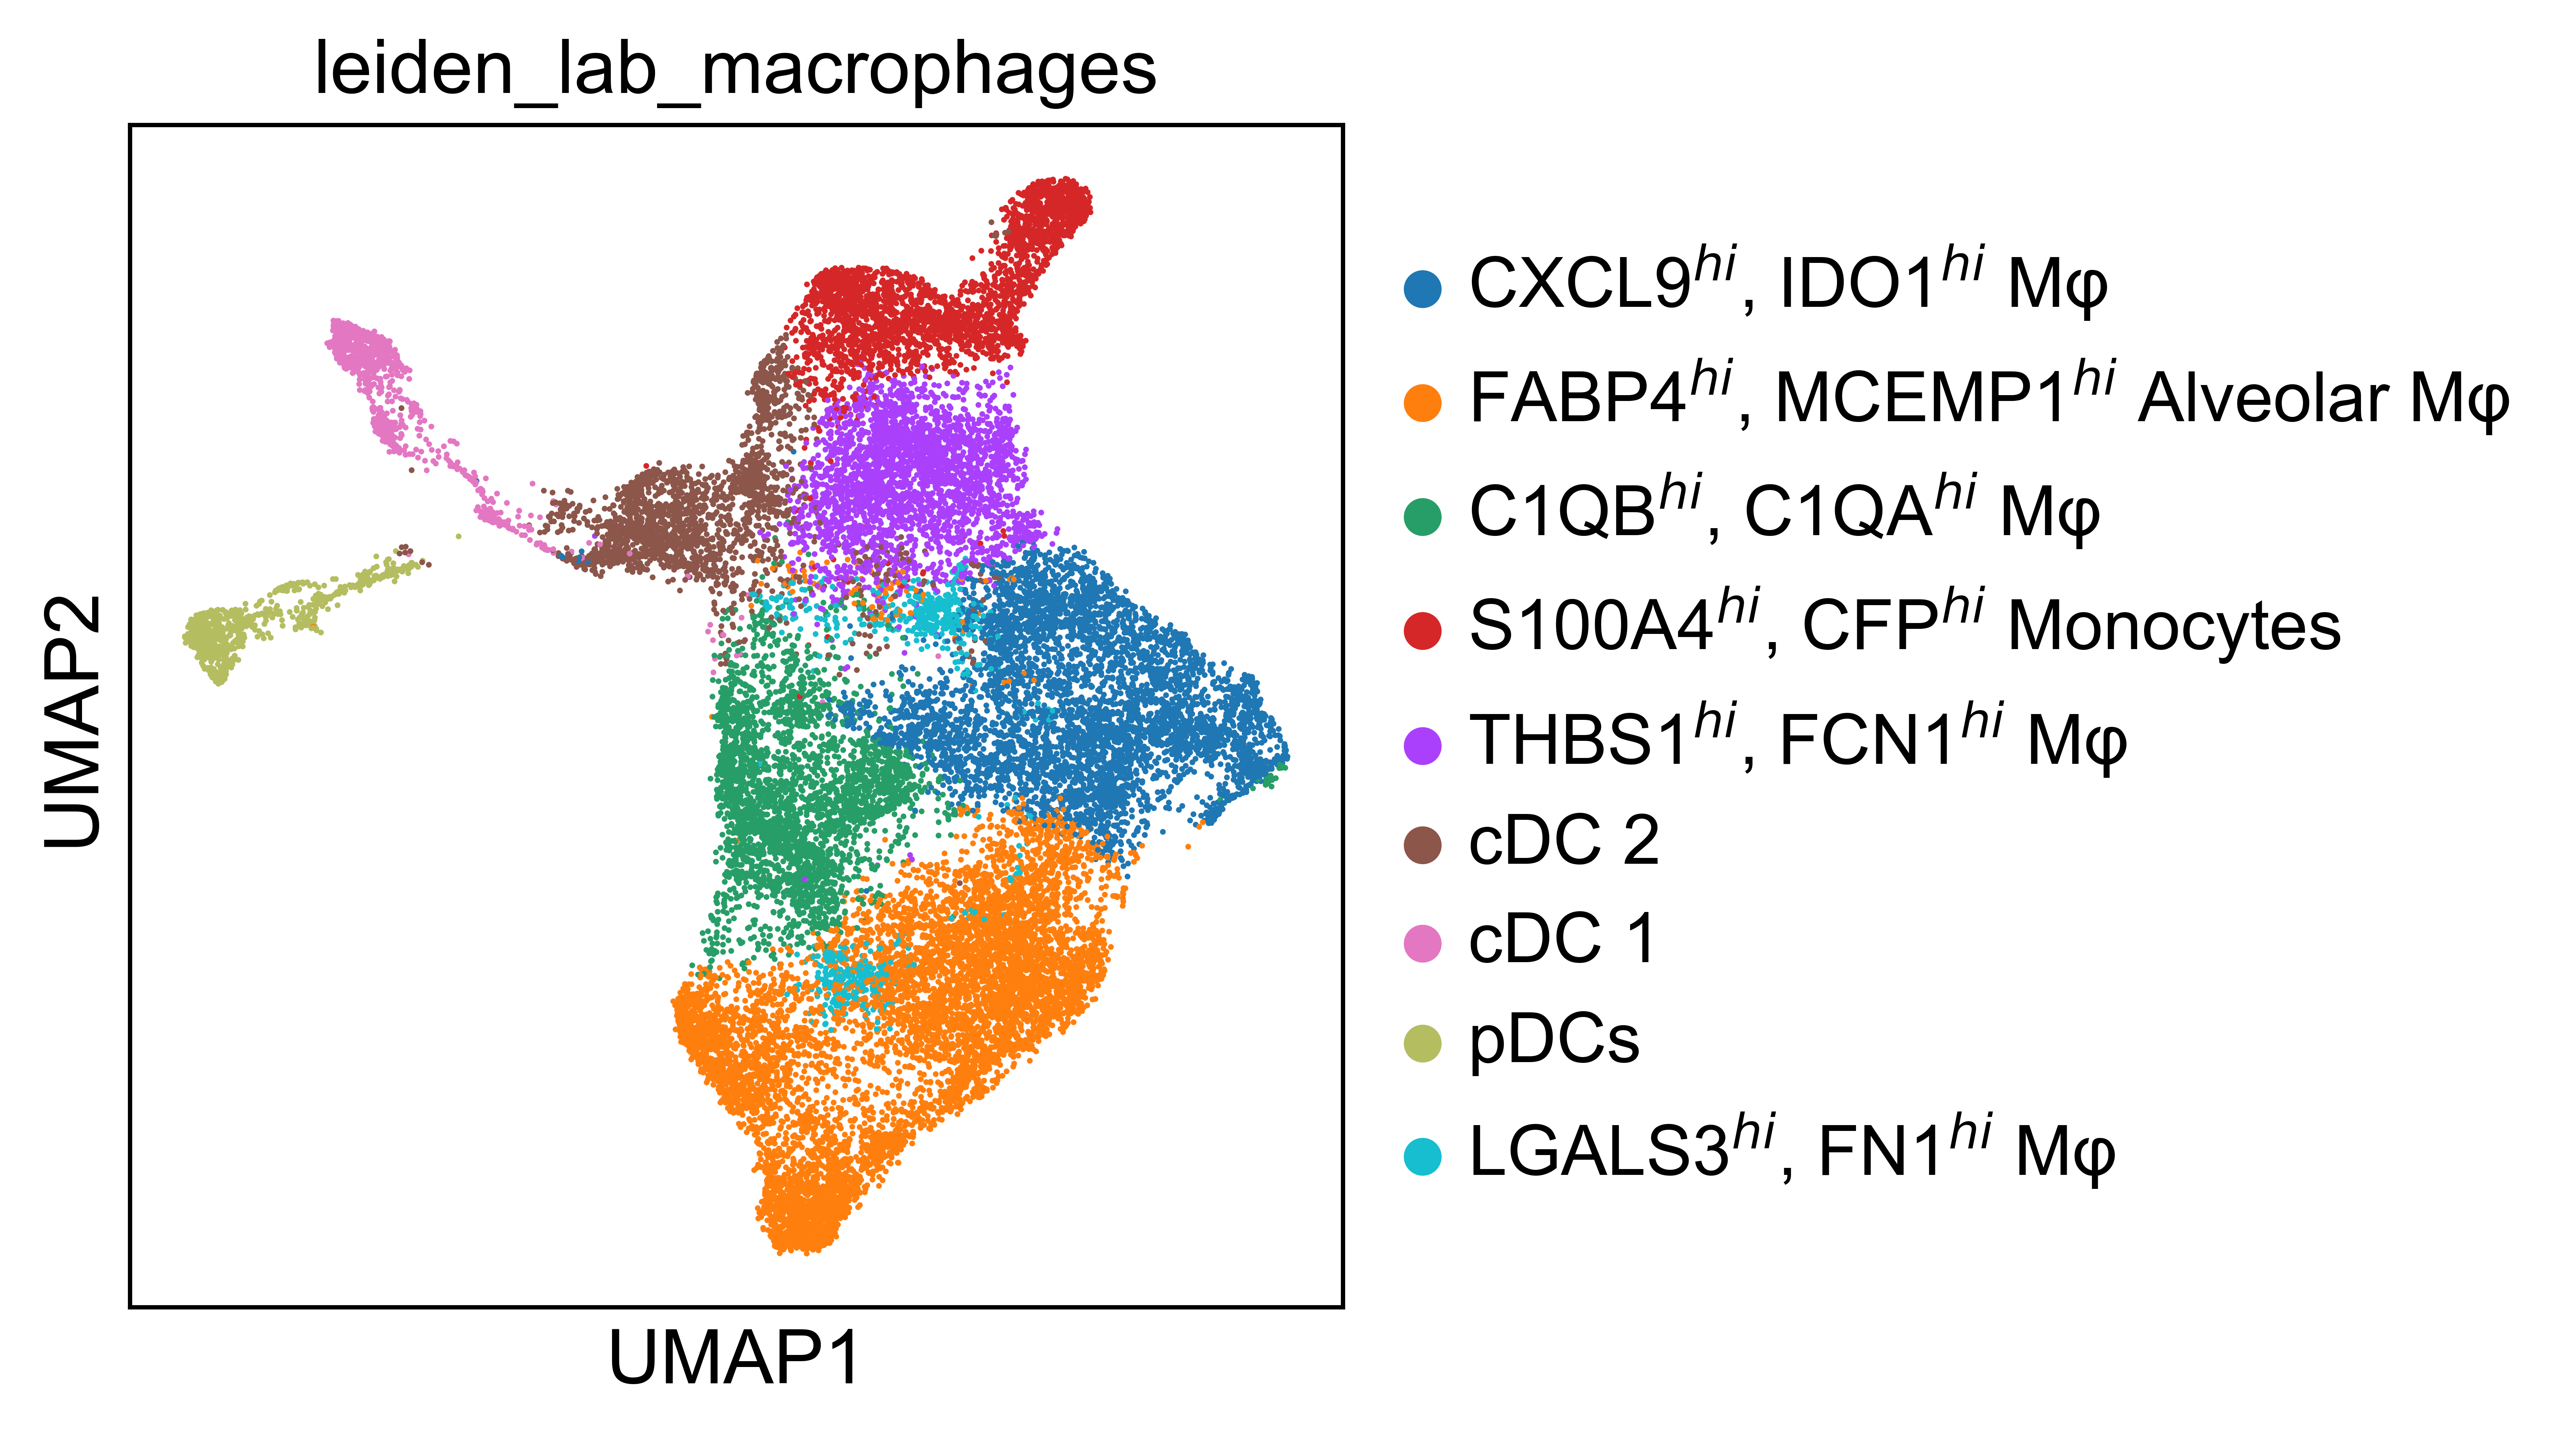

In [30]:
labmap2 = {'0':'CXCL9$^{hi}$, IDO1$^{hi}$ Mφ',
          '1':'FABP4$^{hi}$, MCEMP1$^{hi}$ Alveolar Mφ',
          '2':'FABP4$^{hi}$, MCEMP1$^{hi}$ Alveolar Mφ',
          '3':'C1QB$^{hi}$, C1QA$^{hi}$ Mφ',
          '4':'S100A4$^{hi}$, CFP$^{hi}$ Monocytes',
          '5':'THBS1$^{hi}$, FCN1$^{hi}$ Mφ',
          '6':'cDC 2',
          '7':'cDC 1',
          '8':'pDCs',
          '9':'LGALS3$^{hi}$, FN1$^{hi}$ Mφ'}
adata.obs['leiden_lab_macrophages'] = adata.obs['leiden_res0.6'].replace(labmap2)
sc.pl.umap(adata, color=['leiden_lab_macrophages'])


In [31]:
adata_allcells.obs['Subclustering'] = adata_allcells.obs['Subclustering'].astype(str)
adata_allcells.obs.loc[adata.obs.index, 'Subclustering'] = adata.obs['leiden_lab_macrophages']
#Save adata_allcells h5ad file w/subclustering idents
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
